# Defenza Adversarial Attack: Digito uno. Intento 1

Daremos robustes al clasificador creando una nueva configuración de argumentation en entrenamiento, ya que los datos de entrenamiento son insuficientes para el modelo.

## Pruebas en el modelo original

In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob
import tensorflow as tf

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)


def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor


# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    #resultado = np.argmax(model.predict(image[np.newaxis,:]))
    resultado = model.predict(image[np.newaxis,:])
    return prediction, resultado

# Función que entrega la etiqueta y probabilidad -> decode de respuesta
def get_imagenet_label(probs):
  result = np.where(probs[0] == np.amax(probs[0]))
  max_index = result[0][0]
  probabilidad=probs[0][max_index]
  label = fashion_mnist_labels[max_index] 
  #return  str(label) + " con probabilidad: " + str(probabilidad)
  return  "",label, probabilidad

def display_images(image, description, model):
  #_, label, confidence = get_imagenet_label(model_01.predict(image))
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  #plt.imshow(image[0])
  plt.imshow(np.squeeze(image[0]))
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [4]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


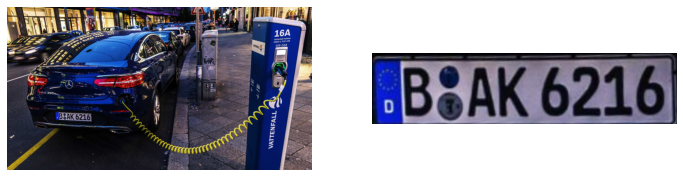

In [5]:
test_image_path = "../img/GettyImages-germanyecars.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

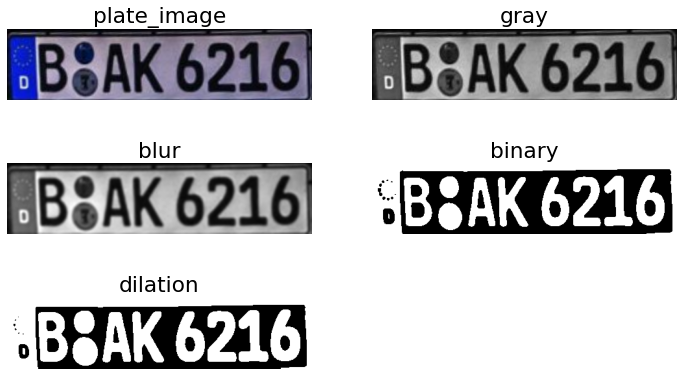

In [6]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

Detect 7 letters...


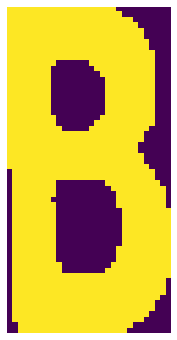

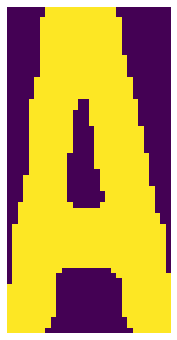

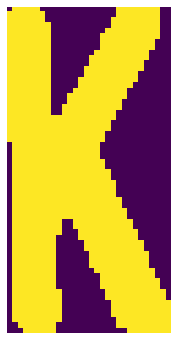

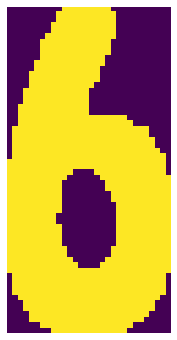

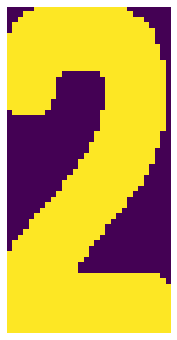

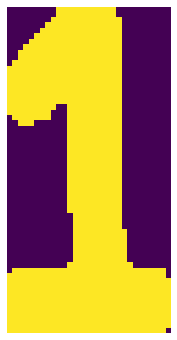

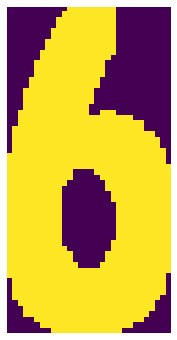

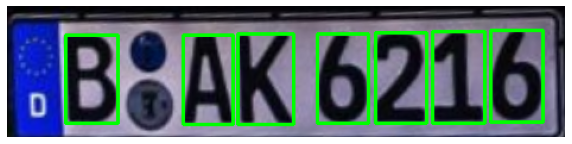

In [7]:

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            """
            fig = plt.figure(figsize=(6,6))
            plt.axis(False)
            plt.imshow(curr_num)
            """
            
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            fig = plt.figure(figsize=(6,6))
            plt.axis(False)
            plt.imshow(curr_num)
            
            crop_characters.append(curr_num)
            
            

print("Detect {} letters...".format(len(crop_characters)))
#fig = plt.figure(figsize=(10,6))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.imshow(fig)
plt.savefig('grab_digit_contour.png',dpi=300)

(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)


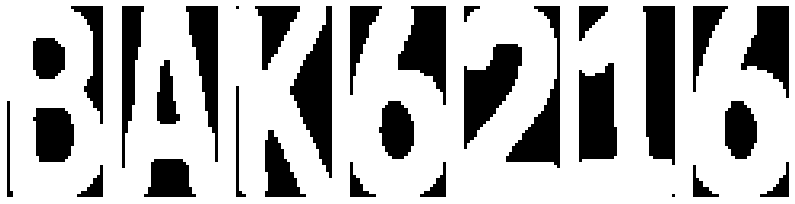

In [8]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
    print(crop_characters[i].shape)

In [9]:
# Load model architecture, weight and labels


json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

[INFO] Model loaded successfully...


In [10]:
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Labels loaded successfully...


In [11]:
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Labels loaded successfully...


In [12]:
adversarial_examples = [
"../img/GettyImages-germanyecars_AE1.jpg",
"../img/GettyImages-germanyecars_AE2.jpg",
"../img/GettyImages-germanyecars_AE3.jpg",
"../img/GettyImages-germanyecars_AE4.jpg",
"../img/GettyImages-germanyecars_AE5.jpg",
"../img/GettyImages-germanyecars_AE6.jpg",
"../img/GettyImages-germanyecars_AE7.jpg",
"../img/GettyImages-germanyecars_AE8.jpg",
"../img/GettyImages-germanyecars_AE9.jpg",
"../img/GettyImages-germanyecars_AE10.jpg",
"../img/GettyImages-germanyecars_AE11.jpg",
"../img/GettyImages-germanyecars_AE12.jpg",
"../img/GettyImages-germanyecars_AE13.jpg",
"../img/GettyImages-germanyecars_AE14.jpg",
"../img/GettyImages-germanyecars_AE15.jpg",
"../img/GettyImages-germanyecars_AE16.jpg",
"../img/GettyImages-germanyecars_AE17.jpg",
"../img/GettyImages-germanyecars_AE18.jpg",
"../img/GettyImages-germanyecars_AE19.jpg",
"../img/GettyImages-germanyecars_AE20.jpg",
"../img/GettyImages-germanyecars_AE21.jpg",
"../img/GettyImages-germanyecars_AE22.jpg",
"../img/GettyImages-germanyecars_AE23.jpg",
"../img/GettyImages-germanyecars_AE24.jpg",
"../img/GettyImages-germanyecars_AE25.jpg"    
]

/home/rodrigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


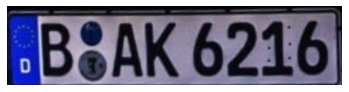

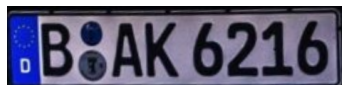

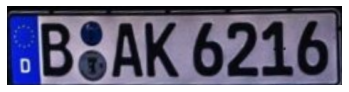

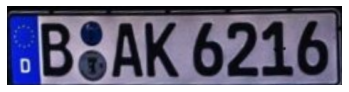

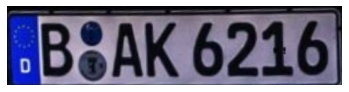

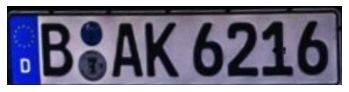

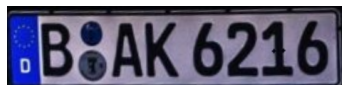

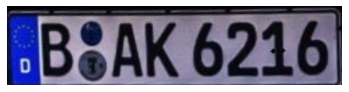

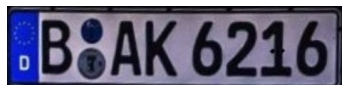

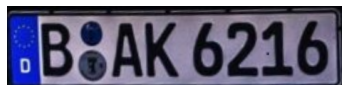

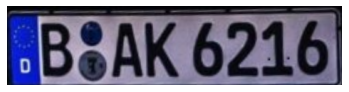

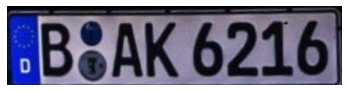

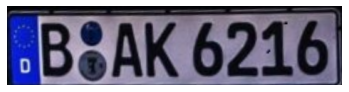

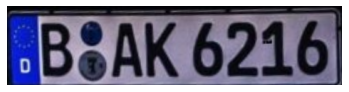

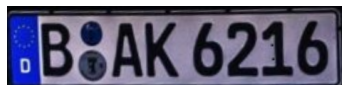

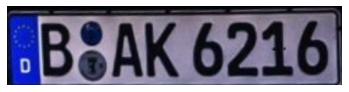

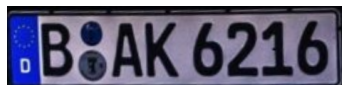

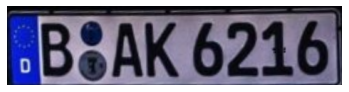

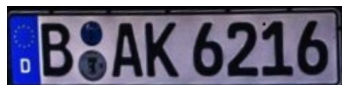

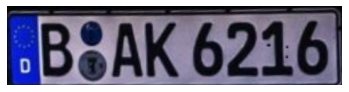

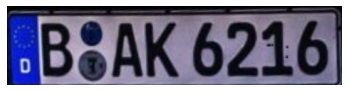

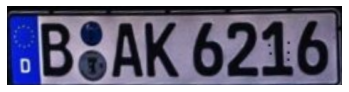

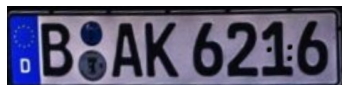

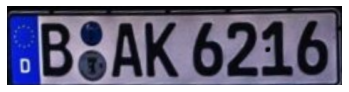

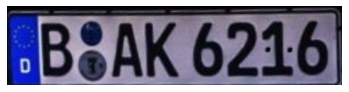

In [13]:
for i,ae in enumerate(adversarial_examples):
    #print(ae)
    test_image_path = ae #fisico01.jpg"
    vehicle, LpImg,cor = get_plate(test_image_path)

    fig = plt.figure(figsize=(6,3))
    plt.axis(False)
    plt.imshow(LpImg[0])

In [14]:
# Load model architecture, weight and labels
import tensorflow as tf

json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")

from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
    
for p,ae in enumerate(adversarial_examples):
    test_image_path = ae
    vehicle, LpImg,cor = get_plate(test_image_path)
    if (len(LpImg)): #check if there is at least one license image
        # Scales, calculates absolute values, and converts the result to 8-bit.
        plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

        # convert to grayscale and blur the image
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)

        # Applied inversed thresh_binary 
        binary = cv2.threshold(blur, 180, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
        ###
        
    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []

    # define standard width and height of character
    digit_w, digit_h = 30, 60

    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1<=ratio<=3.5: # Only select contour with defined ratio
            if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                # Sperate number and gibe prediction
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))        
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)                    
                crop_characters.append(curr_num)


    final_string = ''
    for i,character in enumerate(crop_characters):
        fig.add_subplot(grid[i])
        prediction, resultado = predict_from_model(character,model,labels)
        title = np.array2string(prediction)
        final_string+=title.strip("'[]")


    if final_string == "BAK6216":
        print("imagen nº:" + str(p) +" ,Achieved result: ", final_string + ", resultado correcto")
    else:
        print("imagen nº:" + str(p+1) +" ,Achieved result: ", final_string + ", Fallo en Clasificador!")

imagen nº:0 ,Achieved result:  BAK6216, resultado correcto


/home/rodrigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


imagen nº:1 ,Achieved result:  BAK6216, resultado correcto
imagen nº:2 ,Achieved result:  BAK6216, resultado correcto
imagen nº:3 ,Achieved result:  BAK6216, resultado correcto
imagen nº:4 ,Achieved result:  BAK6216, resultado correcto
imagen nº:6 ,Achieved result:  BAK6236, Fallo en Clasificador!
imagen nº:6 ,Achieved result:  BAK6216, resultado correcto
imagen nº:8 ,Achieved result:  BAK6236, Fallo en Clasificador!
imagen nº:9 ,Achieved result:  BAK6236, Fallo en Clasificador!
imagen nº:9 ,Achieved result:  BAK6216, resultado correcto
imagen nº:10 ,Achieved result:  BAK6216, resultado correcto
imagen nº:12 ,Achieved result:  BAK62I6, Fallo en Clasificador!
imagen nº:13 ,Achieved result:  BAK62T6, Fallo en Clasificador!
imagen nº:13 ,Achieved result:  BAK6216, resultado correcto
imagen nº:14 ,Achieved result:  BAK6216, resultado correcto
imagen nº:15 ,Achieved result:  BAK6216, resultado correcto
imagen nº:16 ,Achieved result:  BAK6216, resultado correcto
imagen nº:17 ,Achieved result

# Haciendo robusta la red

## Defensa: Nueva configuración Argumentation

In [15]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

In [16]:

dataset_paths = glob.glob("Plate_detect_and_recognize/dataset_characters/**/*.jpg")
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)



[INFO] Find 37623 images with 36 classes


In [17]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [18]:
# data augumentation
"""
#OLD
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )
"""
# NEW Parametro de data argumentation
shift_fraction=0.005
# Data argumentation
image_gen = ImageDataGenerator(        
        width_shift_range= shift_fraction,
        height_shift_range= shift_fraction,
        shear_range=0.5,
        zoom_range=(0.9, 1.1),
        horizontal_flip=False,
        vertical_flip=False, 
)


In [19]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [20]:
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

/home/rodrigo/venv/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [21]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="License_character_recognition_defense1.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
529/529 [==============================] - 139s 262ms/step - loss: 1.3290 - accuracy: 0.6575 - val_loss: 1.8464 - val_accuracy: 0.6027

Epoch 00001: saving model to License_character_recognition_defense1.h5
Epoch 2/30
529/529 [==============================] - 125s 237ms/step - loss: 0.3450 - accuracy: 0.9080 - val_loss: 0.6307 - val_accuracy: 0.8480

Epoch 00002: saving model to License_character_recognition_defense1.h5
Epoch 3/30
529/529 [==============================] - 133s 251ms/step - loss: 0.2422 - accuracy: 0.9362 - val_loss: 0.2642 - val_accuracy: 0.9333

Epoch 00003: saving model to License_character_recognition_defense1.h5
Epoch 4/30
529/529 [==============================] - 130s 246ms/step - loss: 0.1674 - accuracy: 0.9525 - val_loss: 0.1952 - val_accuracy: 0.9474

Epoch 00004: saving model to License_character_recognition_defense1.h5
Epoch 5/30
529/529 [==============================] - 130s 247ms/step - loss: 0.1523 - accuracy: 0.9577 - val_loss: 0.1633 - val

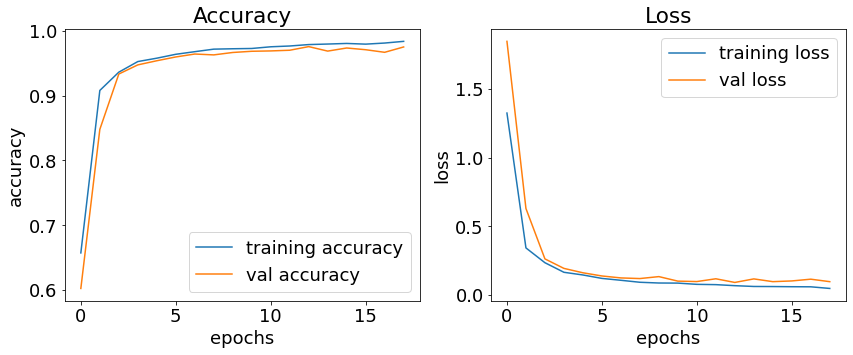

In [22]:

fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#plt.savefig("Training_result.jpg",dpi=300)

In [23]:
# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition_defense1.json", "w") as json_file:
  json_file.write(model_json)
#Guardamos los pesos
model.save_weights("lp01_weights_defense1.h5")

# RETEST

In [24]:
# Load model architecture, weight and labels

json_file = open('MobileNets_character_recognition_defense1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("lp01_weights_defense1.h5")
print("[INFO] Model loaded successfully...")

[INFO] Model loaded successfully...


In [25]:
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Labels loaded successfully...


In [26]:
adversarial_examples = [
"../img/GettyImages-germanyecars_AE1.jpg",
"../img/GettyImages-germanyecars_AE2.jpg",
"../img/GettyImages-germanyecars_AE3.jpg",
"../img/GettyImages-germanyecars_AE4.jpg",
"../img/GettyImages-germanyecars_AE5.jpg",
"../img/GettyImages-germanyecars_AE6.jpg",
"../img/GettyImages-germanyecars_AE7.jpg",
"../img/GettyImages-germanyecars_AE8.jpg",
"../img/GettyImages-germanyecars_AE9.jpg",
"../img/GettyImages-germanyecars_AE10.jpg",
"../img/GettyImages-germanyecars_AE11.jpg",
"../img/GettyImages-germanyecars_AE12.jpg",
"../img/GettyImages-germanyecars_AE13.jpg",
"../img/GettyImages-germanyecars_AE14.jpg",
"../img/GettyImages-germanyecars_AE15.jpg",
"../img/GettyImages-germanyecars_AE16.jpg",
"../img/GettyImages-germanyecars_AE17.jpg",
"../img/GettyImages-germanyecars_AE18.jpg",
"../img/GettyImages-germanyecars_AE19.jpg",
"../img/GettyImages-germanyecars_AE20.jpg",
"../img/GettyImages-germanyecars_AE21.jpg",
"../img/GettyImages-germanyecars_AE22.jpg",
"../img/GettyImages-germanyecars_AE23.jpg",
"../img/GettyImages-germanyecars_AE24.jpg",
"../img/GettyImages-germanyecars_AE25.jpg"    
]

/home/rodrigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


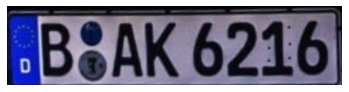

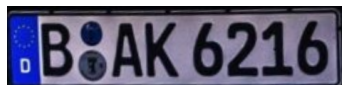

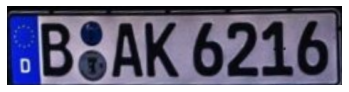

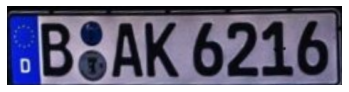

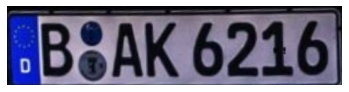

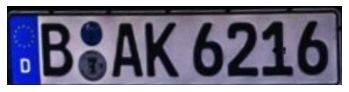

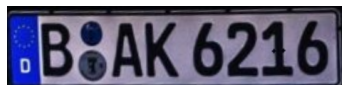

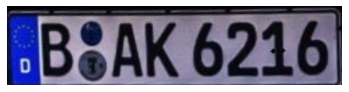

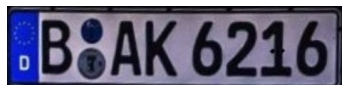

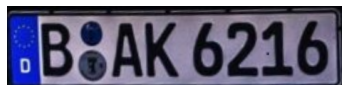

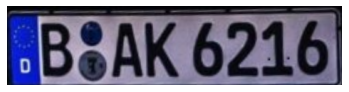

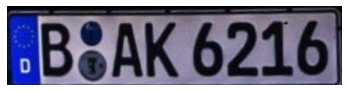

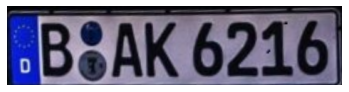

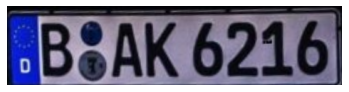

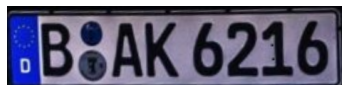

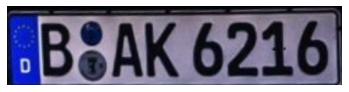

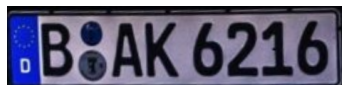

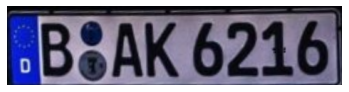

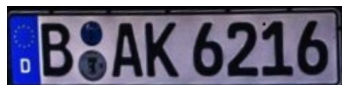

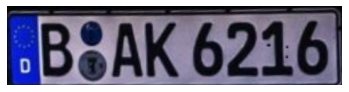

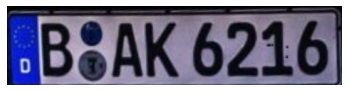

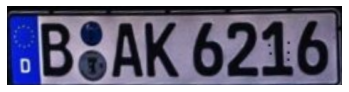

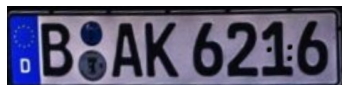

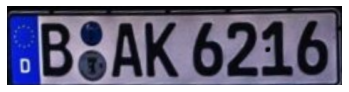

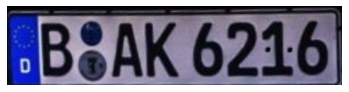

In [27]:
for i,ae in enumerate(adversarial_examples):
    #print(ae)
    test_image_path = ae #fisico01.jpg"
    vehicle, LpImg,cor = get_plate(test_image_path)

    fig = plt.figure(figsize=(6,3))
    plt.axis(False)
    plt.imshow(LpImg[0])

(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)


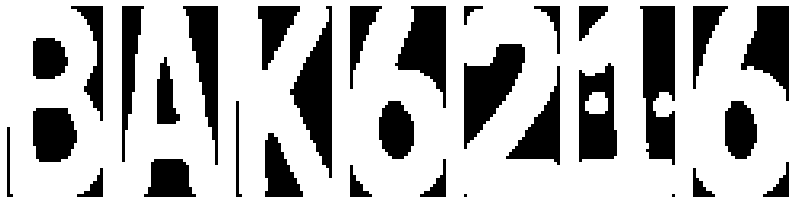

In [28]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
    print(crop_characters[i].shape)

In [30]:
# Load model architecture, weight and labels
import tensorflow as tf

json_file = open('MobileNets_character_recognition_defense1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("lp01_weights_defense1.h5")

from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
    
for p,ae in enumerate(adversarial_examples):
    test_image_path = ae
    vehicle, LpImg,cor = get_plate(test_image_path)
    if (len(LpImg)): #check if there is at least one license image
        # Scales, calculates absolute values, and converts the result to 8-bit.
        plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

        # convert to grayscale and blur the image
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)

        # Applied inversed thresh_binary 
        binary = cv2.threshold(blur, 180, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
        ###
        
    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []

    # define standard width and height of character
    digit_w, digit_h = 30, 60

    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1<=ratio<=3.5: # Only select contour with defined ratio
            if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                # Sperate number and gibe prediction
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))        
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)                    
                crop_characters.append(curr_num)


    final_string = ''
    for i,character in enumerate(crop_characters):
        fig.add_subplot(grid[i])
        prediction, resultado = predict_from_model(character,model,labels)
        title = np.array2string(prediction)
        final_string+=title.strip("'[]")


    if final_string == "BAK6216":
        print("imagen nº:" + str(p) +" ,Achieved result: ", final_string + ", resultado correcto")
    else:
        print("imagen nº:" + str(p+1) +" ,Achieved result: ", final_string + ", Fallo en Clasificador!")

/home/rodrigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


imagen nº:0 ,Achieved result:  BAK6216, resultado correcto
imagen nº:1 ,Achieved result:  BAK6216, resultado correcto
imagen nº:2 ,Achieved result:  BAK6216, resultado correcto
imagen nº:3 ,Achieved result:  BAK6216, resultado correcto
imagen nº:4 ,Achieved result:  BAK6216, resultado correcto
imagen nº:5 ,Achieved result:  BAK6216, resultado correcto
imagen nº:6 ,Achieved result:  BAK6216, resultado correcto
imagen nº:7 ,Achieved result:  BAK6216, resultado correcto
imagen nº:8 ,Achieved result:  BAK6216, resultado correcto
imagen nº:9 ,Achieved result:  BAK6216, resultado correcto
imagen nº:10 ,Achieved result:  BAK6216, resultado correcto
imagen nº:11 ,Achieved result:  BAK6216, resultado correcto
imagen nº:12 ,Achieved result:  BAK6216, resultado correcto
imagen nº:14 ,Achieved result:  BAK62L6, Fallo en Clasificador!
imagen nº:14 ,Achieved result:  BAK6216, resultado correcto
imagen nº:15 ,Achieved result:  BAK6216, resultado correcto
imagen nº:16 ,Achieved result:  BAK6216, resul